In [124]:
import pandas as pd
import numpy as np
import argparse
import itertools
import matplotlib.pyplot as plt

import re
import os
from os import path
import sys
import time

In [141]:
ms= {
    'EbbRT-Node1': 'v',
    'Linux-Node1': 'x',
    'Linux-Node2': '*',
    'Linux-Node3': 'o',
}

df_dict = {
    'qps': [],
    'i' : [],
    'ins': [],
    'cyc': [],
    'refcyc': [],
    'joules': [],
    'tail': [],
}

def resetdict():
    for key in df_dict:
        df_dict[key] = []

def parseLat(s):
    with open(s) as file:
        for line in file:
            #print(line.strip())
            if 'read' in line:
                return float((line.strip().split())[9])

## EbbRT C220G1

In [126]:
qps=0
i=0
#ype='ebbrt_c220g1'
with open("c220g1/mcd/results.md") as file:
    for line in file:        
        ins=0
        cyc=0
        refcyc=0
        joules=0.0
        if "MQPS" in line.strip():
            qps = int(line.strip().split(' ')[2])
            i = 0
        elif "[STATS ALL]" in line.strip():            
            tmp = line.strip().split(' ')
            #print(tmp)
            ins = int(tmp[2])
            cyc = int(tmp[3])
            refcyc = int(tmp[4])
            joules = float(tmp[5])

            #df_dict['type'].append(type)
            df_dict['qps'].append(qps)
            df_dict['i'].append(i)
            df_dict['ins'].append(ins)
            df_dict['cyc'].append(cyc)
            df_dict['refcyc'].append(refcyc)
            df_dict['joules'].append(joules)
            df_dict['tail'].append(parseLat(f"c220g1/mcd/ebbrtbm_qps{qps}_iter{i}.out"))
            i += 1
df = pd.DataFrame(df_dict)
qpss=df['qps'].unique()
dfebbrt = df.groupby(['qps']).mean()
dfebbrt['ipc'] = dfebbrt['ins']/dfebbrt['refcyc']
dfebbrt=dfebbrt.drop(columns=['i'])
dfebbrt['qps'] = qpss
dfebbrt['kqps']=[int(x / 1000) for x in qpss]
dfebbrt['type']='EbbRT-Node1'
print(dfebbrt)

                  ins           cyc        refcyc       joules      tail  \
qps                                                                        
200000   4.777431e+10  1.154030e+11  1.194927e+11  1605.865000    96.225   
400000   9.507178e+10  2.118485e+11  2.044379e+11  1736.340000    96.125   
600000   1.422908e+11  3.022215e+11  2.843202e+11  1771.232500    96.125   
800000   1.893191e+11  3.853599e+11  3.584828e+11  1860.865000    95.900   
1000000  2.363764e+11  4.638384e+11  4.294849e+11  1947.627500    96.050   
1200000  2.836647e+11  5.395560e+11  4.986063e+11  1975.082500    96.200   
1400000  3.303890e+11  6.078982e+11  5.613737e+11  2077.532500    96.100   
1600000  3.778211e+11  6.791168e+11  6.269814e+11  2152.235000    96.200   
1800000  4.251856e+11  7.451455e+11  6.878753e+11  2200.093333    96.300   
2000000  4.725948e+11  8.104864e+11  7.481646e+11  2253.220000    96.550   
2200000  5.206181e+11  8.726308e+11  8.055277e+11  2329.455000    98.700   
2400000  5.6

## Validate noise in EbbRT

In [127]:
dfebbrtstd = df.groupby(['qps']).std()
dfebbrtstd['qps']=qpss
maxerr=0.0
for mqps in range(200000, 3000000, 200000):
    for metric in ['ins', 'cyc', 'refcyc', 'joules']:
        meanm=round(float(dfebbrt[(dfebbrt['qps'] == mqps)][metric]), 2)
        stdm=round(float(dfebbrtstd[(dfebbrtstd['qps'] == mqps)][metric]),2)
        #print(mqps, metric, round((stdm/meanm)*100.0, 2))
        maxerr=max(maxerr, round((stdm/meanm)*100.0, 2))
print(f"Largest error in EbbRT was {maxerr}% of mean")

Largest error in EbbRT was 2.82% of mean



## Linux C220G1

In [129]:
## Overheads
resetdict()

ins_oh_arr=[]
cyc_oh_arr=[]
refcyc_oh_arr=[]
joules_oh_arr=[]

ins_oh=0
cyc_oh=0
refcyc_oh=0
joules_oh=0.0

for i in range (0, 4):    
    with open(f"c220g1/linux_mcd/PerfStat.Overhead.iter{i}") as file:
        for line in file:      
            if 'instructions' in line:
                ins_oh_arr.append(int((line.strip().split(','))[0]))
            elif "ref-cycles" in line:
                refcyc_oh_arr.append(int((line.strip().split(','))[0]))
            elif 'cycles' in line:
                cyc_oh_arr.append(int((line.strip().split(','))[0]))
            elif 'Joules' in line:
                joules_oh_arr.append(float((line.strip().split(','))[0]))
ins_oh = np.mean(ins_oh_arr)
cyc_oh = np.mean(cyc_oh_arr)
refcyc_oh = np.mean(refcyc_oh_arr)
joules_oh = np.mean(joules_oh_arr)

print(ins_oh, cyc_oh, refcyc_oh, joules_oh)
#type='linux_c220g1'
for mqps in range(200000, 1200000, 200000):
    for iter in range(0, 5):
        if os.path.exists(f"c220g1/linux_mcd/PerfStat.linux_mcd_qps{mqps}_iter{iter}"):
            ins=0
            cyc=0
            refcyc=0
            joules=0.0
            with open(f"c220g1/linux_mcd/PerfStat.linux_mcd_qps{mqps}_iter{iter}") as file:
                for line in file:  
                    if 'instructions' in line:
                        ins = int((line.strip().split(','))[0]) - ins_oh
                    elif "ref-cycles" in line:
                        refcyc = int((line.strip().split(','))[0]) - cyc_oh
                    elif 'cycles' in line:
                        cyc = int((line.strip().split(','))[0]) - refcyc_oh
                    elif 'Joules' in line:
                        joules = float((line.strip().split(','))[0]) - joules_oh
            tail = parseLat(f"c220g1/linux_mcd/linux_mcd_qps{mqps}_iter{iter}.out")
            #df_dict['type'].append(type)
            df_dict['qps'].append(mqps)
            df_dict['i'].append(iter)
            df_dict['ins'].append(ins)
            df_dict['cyc'].append(cyc)
            df_dict['refcyc'].append(refcyc)
            df_dict['joules'].append(joules)
            df_dict['tail'].append(tail)


8552732973.5 25807605024.25 29585660346.0 473.26750000000004


In [130]:
df = pd.DataFrame(df_dict)
qpss=df['qps'].unique()
dflinux_c220g1 = df.groupby(['qps']).mean()
dflinux_c220g1['ipc'] = dflinux_c220g1['ins']/dflinux_c220g1['refcyc']
dflinux_c220g1=dflinux_c220g1.drop(columns=['i'])
dflinux_c220g1['qps'] = qpss
dflinux_c220g1['kqps']=[int(x / 1000) for x in qpss]
dflinux_c220g1['type']='Linux-Node1'
print(dflinux_c220g1)


                  ins           cyc        refcyc     joules      tail  \
qps                                                                      
200000   2.396295e+11  4.821708e+11  4.556133e+11  1833.7625   115.350   
400000   4.344078e+11  8.974446e+11  8.358215e+11  2190.0125   118.700   
600000   5.955976e+11  1.294279e+12  1.202104e+12  2472.3025   145.350   
800000   7.294787e+11  1.606924e+12  1.490834e+12  2660.8025   224.925   
1000000  8.317961e+11  1.836587e+12  1.702763e+12  2786.5425  1156.775   

              ipc      qps  kqps         type  
qps                                            
200000   0.525949   200000   200  Linux-Node1  
400000   0.519738   400000   400  Linux-Node1  
600000   0.495463   600000   600  Linux-Node1  
800000   0.489309   800000   800  Linux-Node1  
1000000  0.488498  1000000  1000  Linux-Node1  


## Validate noise in linux_c220g1

In [131]:
dflinux_c220g1std = df.groupby(['qps']).std()
dflinux_c220g1std['qps']=qpss
maxerr=0.0
for mqps in range(200000, 1200000, 200000):
    for metric in ['ins', 'cyc', 'refcyc', 'joules']:
        meanm=round(float(dflinux_c220g1[(dflinux_c220g1['qps'] == mqps)][metric]), 2)
        stdm=round(float(dflinux_c220g1std[(dflinux_c220g1std['qps'] == mqps)][metric]),2)
        #print(mqps, metric, round((stdm/meanm)*100.0, 2))
        maxerr=max(maxerr, round((stdm/meanm)*100.0, 2))
print(f"Largest error in dflinux_c220g1 was {maxerr}% of mean")

Largest error in dflinux_c220g1 was 1.75% of mean


## Linux C220G5

In [132]:
## Overheads
resetdict()

ins_oh_arr=[]
cyc_oh_arr=[]
refcyc_oh_arr=[]
joules_oh_arr=[]

ins_oh=0
cyc_oh=0
refcyc_oh=0
joules_oh=0.0

for i in range (0, 4):    
    with open(f"c220g5/linux_mcd/PerfStat.Overhead.iter{i}") as file:
        for line in file:      
            if 'instructions' in line:
                ins_oh_arr.append(int((line.strip().split(','))[0]))
            elif "ref-cycles" in line:
                refcyc_oh_arr.append(int((line.strip().split(','))[0]))
            elif 'cycles' in line:
                cyc_oh_arr.append(int((line.strip().split(','))[0]))
            elif 'Joules' in line:
                joules_oh_arr.append(float((line.strip().split(','))[0]))
ins_oh = np.mean(ins_oh_arr)
cyc_oh = np.mean(cyc_oh_arr)
refcyc_oh = np.mean(refcyc_oh_arr)
joules_oh = np.mean(joules_oh_arr)

print(ins_oh, cyc_oh, refcyc_oh, joules_oh)
#type='linux_c220g5'
for mqps in range(200000, 1400000, 200000):
    for iter in range(0, 5):
        if os.path.exists(f"c220g5/linux_mcd/PerfStat.linux_mcd_qps{mqps}_iter{iter}"):
            ins=0
            cyc=0
            refcyc=0
            joules=0.0
            with open(f"c220g5/linux_mcd/PerfStat.linux_mcd_qps{mqps}_iter{iter}") as file:
                for line in file:  
                    if 'instructions' in line:
                        ins = int((line.strip().split(','))[0]) - ins_oh
                    elif "ref-cycles" in line:
                        refcyc = int((line.strip().split(','))[0]) - cyc_oh
                    elif 'cycles' in line:
                        cyc = int((line.strip().split(','))[0]) - refcyc_oh
                    elif 'Joules' in line:
                        joules = float((line.strip().split(','))[0]) - joules_oh
            tail = parseLat(f"c220g5/linux_mcd/linux_mcd_qps{mqps}_iter{iter}.out")
            #df_dict['type'].append(type)
            df_dict['qps'].append(mqps)
            df_dict['i'].append(iter)
            df_dict['ins'].append(ins)
            df_dict['cyc'].append(cyc)
            df_dict['refcyc'].append(refcyc)
            df_dict['joules'].append(joules)
            df_dict['tail'].append(tail)


9154589549.5 16178511631.0 30781449864.0 797.595


In [133]:
df = pd.DataFrame(df_dict)
qpss=df['qps'].unique()
dflinux_c220g5 = df.groupby(['qps']).mean()
dflinux_c220g5['ipc'] = dflinux_c220g5['ins']/dflinux_c220g5['refcyc']
dflinux_c220g5=dflinux_c220g5.drop(columns=['i'])
dflinux_c220g5['qps'] = qpss
dflinux_c220g5['kqps']=[int(x / 1000) for x in qpss]
dflinux_c220g5['type']='Linux-Node2'
print(dflinux_c220g5)

## Validate noise in linux_c220g5
dflinux_c220g5std = df.groupby(['qps']).std()
dflinux_c220g5std['qps']=qpss
maxerr=0.0
for mqps in range(200000, 1400000, 200000):
    for metric in ['ins', 'cyc', 'refcyc', 'joules']:
        meanm=round(float(dflinux_c220g5[(dflinux_c220g5['qps'] == mqps)][metric]), 2)
        stdm=round(float(dflinux_c220g5std[(dflinux_c220g5std['qps'] == mqps)][metric]),2)
        #print(mqps, metric, round((stdm/meanm)*100.0, 2))
        maxerr=max(maxerr, round((stdm/meanm)*100.0, 2))
print(f"Largest error in dflinux_c220g5 was {maxerr}% of mean")

                  ins           cyc        refcyc     joules      tail  \
qps                                                                      
200000   2.345799e+11  4.438587e+11  4.642638e+11  2440.2475   112.050   
400000   4.274637e+11  8.685091e+11  7.959224e+11  2760.4925   113.025   
600000   5.965455e+11  1.278444e+12  1.152519e+12  3091.4475   126.400   
800000   7.404213e+11  1.656957e+12  1.485269e+12  3286.3700   165.500   
1000000  8.497317e+11  1.976706e+12  1.767230e+12  3462.2425   332.625   
1200000  9.262510e+11  2.236816e+12  1.995912e+12  3587.9375  1844.450   

              ipc      qps  kqps         type  
qps                                            
200000   0.505273   200000   200  Linux-Node2  
400000   0.537067   400000   400  Linux-Node2  
600000   0.517602   600000   600  Linux-Node2  
800000   0.498510   800000   800  Linux-Node2  
1000000  0.480827  1000000  1000  Linux-Node2  
1200000  0.464074  1200000  1200  Linux-Node2  
Largest error in dflinu

## Linux sm220u

In [134]:
## Overheads
resetdict()

ins_oh_arr=[]
cyc_oh_arr=[]
refcyc_oh_arr=[]
joules_oh_arr=[]

ins_oh=0
cyc_oh=0
refcyc_oh=0
joules_oh=0.0

for i in range (0, 4):    
    with open(f"sm220u/linux_mcd/PerfStat.Overhead.iter{i}") as file:
        for line in file:      
            if 'instructions' in line:
                ins_oh_arr.append(int((line.strip().split(','))[0]))
            elif "ref-cycles" in line:
                refcyc_oh_arr.append(int((line.strip().split(','))[0]))
            elif 'cycles' in line:
                cyc_oh_arr.append(int((line.strip().split(','))[0]))
            elif 'Joules' in line:
                joules_oh_arr.append(float((line.strip().split(','))[0]))
ins_oh = np.mean(ins_oh_arr)
cyc_oh = np.mean(cyc_oh_arr)
refcyc_oh = np.mean(refcyc_oh_arr)
joules_oh = np.mean(joules_oh_arr)

print(ins_oh, cyc_oh, refcyc_oh, joules_oh)
#type='linux_sm220u'
for mqps in range(200000, 2000000, 200000):
    for iter in range(0, 5):
        if os.path.exists(f"sm220u/linux_mcd/PerfStat.linux_mcd_qps{mqps}_iter{iter}"):
            ins=0
            cyc=0
            refcyc=0
            joules=0.0
            with open(f"sm220u/linux_mcd/PerfStat.linux_mcd_qps{mqps}_iter{iter}") as file:
                for line in file:  
                    if 'instructions' in line:
                        ins = int((line.strip().split(','))[0]) - ins_oh
                    elif "ref-cycles" in line:
                        refcyc = int((line.strip().split(','))[0]) - cyc_oh
                    elif 'cycles' in line:
                        cyc = int((line.strip().split(','))[0]) - refcyc_oh
                    elif 'Joules' in line:
                        joules = float((line.strip().split(','))[0]) - joules_oh
            tail = parseLat(f"sm220u/linux_mcd/linux_mcd_qps{mqps}_iter{iter}.out")
            #df_dict['type'].append(type)
            df_dict['qps'].append(mqps)
            df_dict['i'].append(iter)
            df_dict['ins'].append(ins)
            df_dict['cyc'].append(cyc)
            df_dict['refcyc'].append(refcyc)
            df_dict['joules'].append(joules)
            df_dict['tail'].append(tail)


12272974035.5 18009374205.0 16088977368.0 2465.2675


In [135]:
df = pd.DataFrame(df_dict)
qpss=df['qps'].unique()
dflinux_sm220u = df.groupby(['qps']).mean()
dflinux_sm220u['ipc'] = dflinux_sm220u['ins']/dflinux_sm220u['refcyc']
dflinux_sm220u=dflinux_sm220u.drop(columns=['i'])
dflinux_sm220u['qps'] = qpss
dflinux_sm220u['kqps']=[int(x / 1000) for x in qpss]
dflinux_sm220u['type']='Linux-Node3'
print(dflinux_sm220u)

## Validate noise in linux_c220g5
dflinux_sm220ustd = df.groupby(['qps']).std()
dflinux_sm220ustd['qps']=qpss
maxerr=0.0
for mqps in range(200000, 2000000, 200000):
    for metric in ['ins', 'cyc', 'refcyc', 'joules']:
        meanm=round(float(dflinux_sm220u[(dflinux_sm220u['qps'] == mqps)][metric]), 2)
        stdm=round(float(dflinux_sm220ustd[(dflinux_sm220ustd['qps'] == mqps)][metric]),2)
        #print(mqps, metric, round((stdm/meanm)*100.0, 2))
        maxerr=max(maxerr, round((stdm/meanm)*100.0, 2))
print(f"Largest error in dflinux_sm220u was {maxerr}% of mean")

                  ins           cyc        refcyc     joules      tail  \
qps                                                                      
200000   2.820915e+11  4.581505e+11  3.735584e+11  5214.6425   127.350   
400000   5.192688e+11  8.687092e+11  7.138838e+11  5566.3400   145.600   
600000   7.401712e+11  1.269495e+12  1.046763e+12  5883.7900   175.050   
800000   9.474439e+11  1.660782e+12  1.370976e+12  6189.0850   193.600   
1000000  1.140180e+12  2.011575e+12  1.661364e+12  6459.6575   203.175   
1200000  1.315075e+12  2.330477e+12  1.925283e+12  6679.8450   214.925   
1400000  1.468599e+12  2.645898e+12  2.186365e+12  6892.5075   238.600   
1600000  1.597888e+12  3.025271e+12  2.500314e+12  7104.0075   373.050   
1800000  1.432263e+12  4.858083e+12  4.017073e+12  7299.7950  3023.325   

              ipc      qps  kqps         type  
qps                                            
200000   0.755147   200000   200  Linux-Node3  
400000   0.727386   400000   400  Linux-N

In [136]:
for df in [dfebbrt, dflinux_c220g1, dflinux_c220g5, dflinux_sm220u]:
    df['rpj'] = df['qps']*30/df['joules']

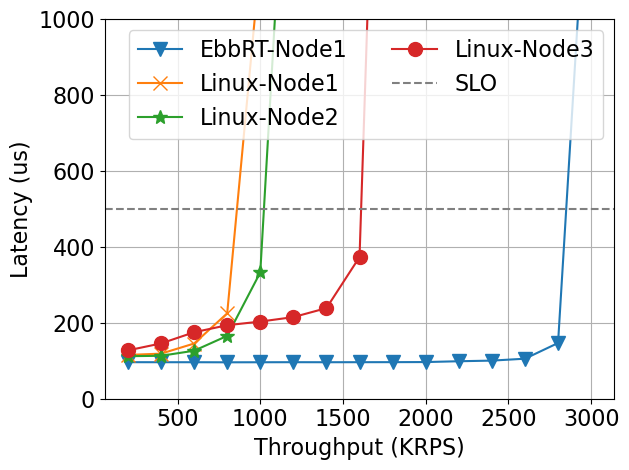

In [144]:
fs=16
plt.rc('axes', labelsize=fs)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=fs)    # fontsize of the tick labels
plt.rc('ytick', labelsize=fs)    # fontsize of the tick labels

# Plot 99 tail
for df in [dfebbrt, dflinux_c220g1, dflinux_c220g5, dflinux_sm220u]:
    plt.plot(df['kqps'], df['tail'], marker=ms[str(df['type'].unique()[0])], markersize=10, ls='-', label=str(df['type'].unique()[0]))
plt.axhline(y = 500, color = 'grey', linestyle = '--', label='SLO') 
plt.xlabel("Throughput (KRPS)", fontsize=fs)
plt.ylabel("Latency (us)", fontsize=fs)
plt.ylim(bottom=0, top=1000)
plt.grid()
plt.legend(ncols=2, fontsize=fs)
#plt.show()
plt.tight_layout()
plt.savefig("mcd_latency.pdf")

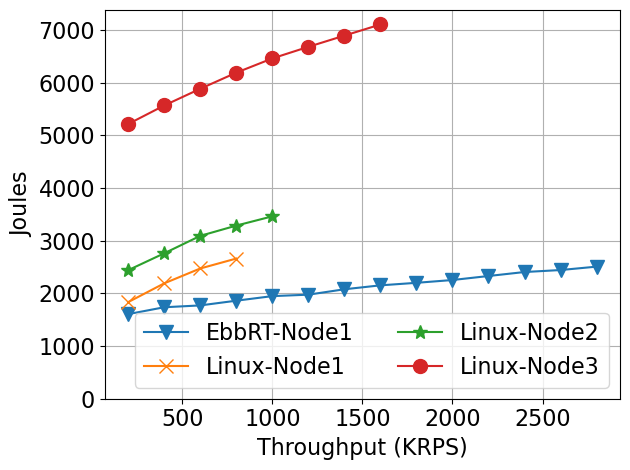

In [153]:
fs=16
plt.rc('axes', labelsize=fs)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=fs)    # fontsize of the tick labels
plt.rc('ytick', labelsize=fs)    # fontsize of the tick labels

for df in [dfebbrt, dflinux_c220g1, dflinux_c220g5, dflinux_sm220u]:
    plt.plot(df['kqps'][:-1], df['joules'][:-1], marker=ms[str(df['type'].unique()[0])], markersize=10, ls='-', label=str(df['type'].unique()[0]))
plt.xlabel("Throughput (KRPS)", fontsize=fs)
plt.ylabel("Joules", fontsize=fs)
plt.ylim(bottom=0)
plt.grid()
plt.legend(ncols=2, fontsize=fs)
plt.tight_layout()
plt.savefig("mcd_joules.pdf")
#plt.show()

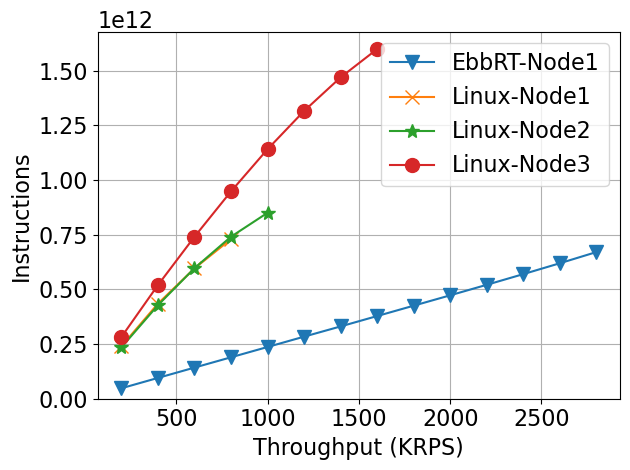

In [155]:
fs=16
plt.rc('axes', labelsize=fs)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=fs)    # fontsize of the tick labels
plt.rc('ytick', labelsize=fs)    # fontsize of the tick labels

for df in [dfebbrt, dflinux_c220g1, dflinux_c220g5, dflinux_sm220u]:
    plt.plot(df['kqps'][:-1], df['ins'][:-1], marker=ms[str(df['type'].unique()[0])], markersize=10, ls='-', label=str(df['type'].unique()[0]))
plt.xlabel("Throughput (KRPS)", fontsize=fs)
plt.ylabel("Instructions", fontsize=fs)
plt.ylim(bottom=0)
plt.grid()
plt.legend(ncols=1, fontsize=fs)
plt.tight_layout()
plt.savefig("mcd_instructions.pdf")
#plt.show()

In [63]:

    
def mplot(x, y, ylimt=-1):   
    for df in [dfebbrt, dflinux_c220g1, dflinux_c220g5, dflinux_sm220u]:
        plt.plot(df[x][:-1], df[y][:-1],'-o')
    plt.xlabel(x)
    plt.ylabel(y)

    if ylimt != -1:
        plt.ylim(bottom=0, top=ylimt)
    else:
        plt.ylim(bottom=0)
    plt.legend()
    plt.show()

In [64]:
dfebbrt.columns

Index(['ins', 'cyc', 'refcyc', 'joules', 'tail', 'type', 'ipc', 'qps', 'rpj'], dtype='object')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


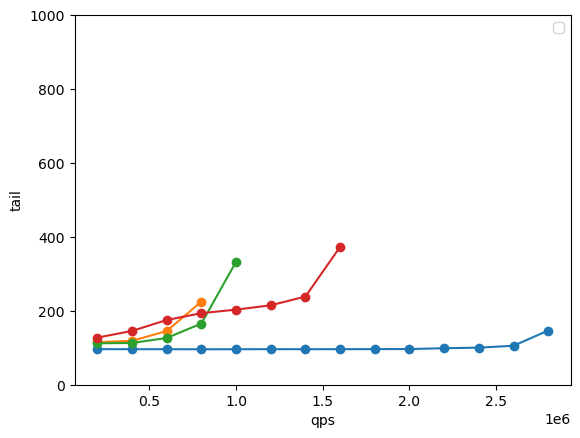

In [60]:
mplot('qps', 'tail', 1000)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


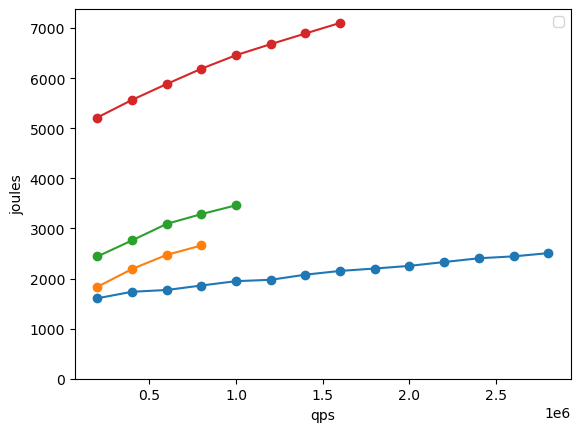

In [61]:
mplot('qps', 'joules')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


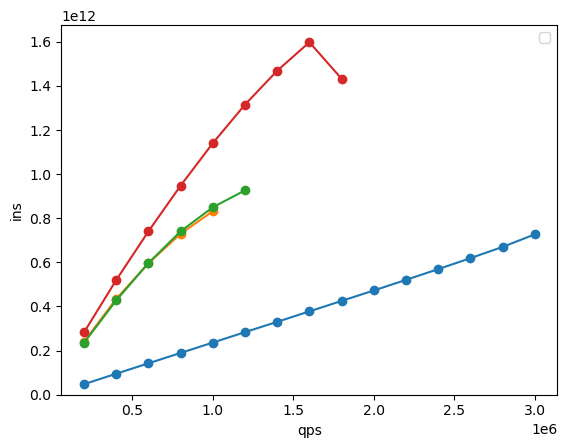

In [56]:
mplot('qps', 'ins')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


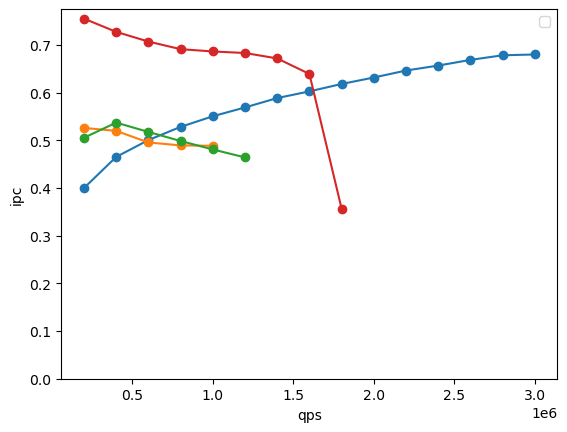

In [57]:
mplot('qps', 'ipc')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


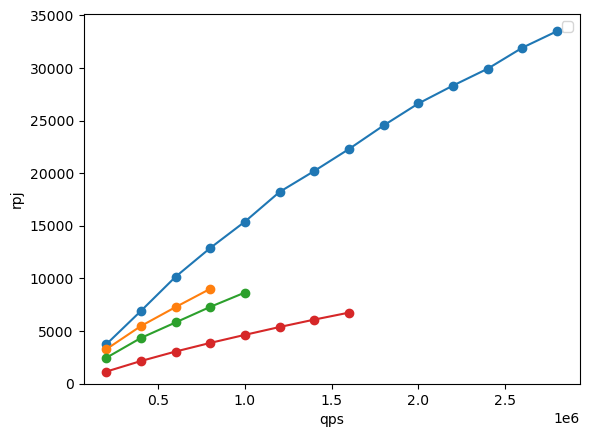

In [65]:
mplot('qps', 'rpj')